In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Importing Datasets

In [3]:
train_raw = pd.read_csv("Complete-Dataset\Phising_Training_Dataset.csv", header = 0)
train_raw.head(5)

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,12344,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,12345,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,12346,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,12347,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,12348,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [4]:
test_raw = pd.read_csv("Complete-Dataset\Phising_Testing_Dataset.csv", header = 0)
test_raw.head(5)

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
0,21338,1,1,1,1,1,1,-1,1,-1,...,1,1,1,1,1,1,1,-1,0,1
1,21339,1,-1,1,1,1,-1,0,-1,1,...,1,1,1,-1,-1,0,-1,-1,0,1
2,21340,1,-1,1,1,1,-1,0,0,-1,...,-1,-1,-1,1,-1,1,-1,1,1,-1
3,21341,-1,-1,-1,1,-1,-1,-1,-1,1,...,1,-1,-1,1,-1,1,-1,1,1,-1
4,21342,1,-1,1,1,1,-1,1,1,-1,...,1,1,1,1,1,1,-1,1,0,1


### Class Imbalance Check

In [9]:
train_raw.groupby('Result').count()

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
Result,,,,,,,,,,,,,,,,,,,,,
-1,3921,3921,3921,3921,3921,3921,3921,3921,3921,3921,...,3921,3921,3921,3921,3921,3921,3921,3921,3921,3921
1,5034,5034,5034,5034,5034,5034,5034,5034,5034,5034,...,5034,5034,5034,5034,5034,5034,5034,5034,5034,5034


So we see that 5034 legitimate sites and 3921 phishing sites are present in the dataset. Which seems to not be of great imbalance to the overall data size.

We may now look for missing values, if present can be imputed by the mode of each feature. 

### Missing Value Check

In [22]:
train_raw.isna().sum()

key                            0
having_IP                      0
URL_Length                     0
Shortining_Service             0
having_At_Symbol               0
double_slash_redirecting       0
Prefix_Suffix                  0
having_Sub_Domain              0
SSLfinal_State                 0
Domain_registeration_length    0
Favicon                        0
port                           0
HTTPS_token                    0
Request_URL                    0
URL_of_Anchor                  0
Links_in_tags                  0
SFH                            0
Submitting_to_email            0
Abnormal_URL                   0
Redirect                       0
on_mouseover                   0
RightClick                     0
popUpWidnow                    0
Iframe                         0
age_of_domain                  0
DNSRecord                      0
web_traffic                    0
Page_Rank                      0
Google_Index                   0
Links_pointing_to_page         0
Statistica

We don't seem to have any missing values. 

As per the description given in hackathon webpage, we observe that all the features are categorical variables with values -1, (0), and 1. We may now look at the correlation between these variables and check if we can reduce the number of features using some dimension reductionality algorithm.

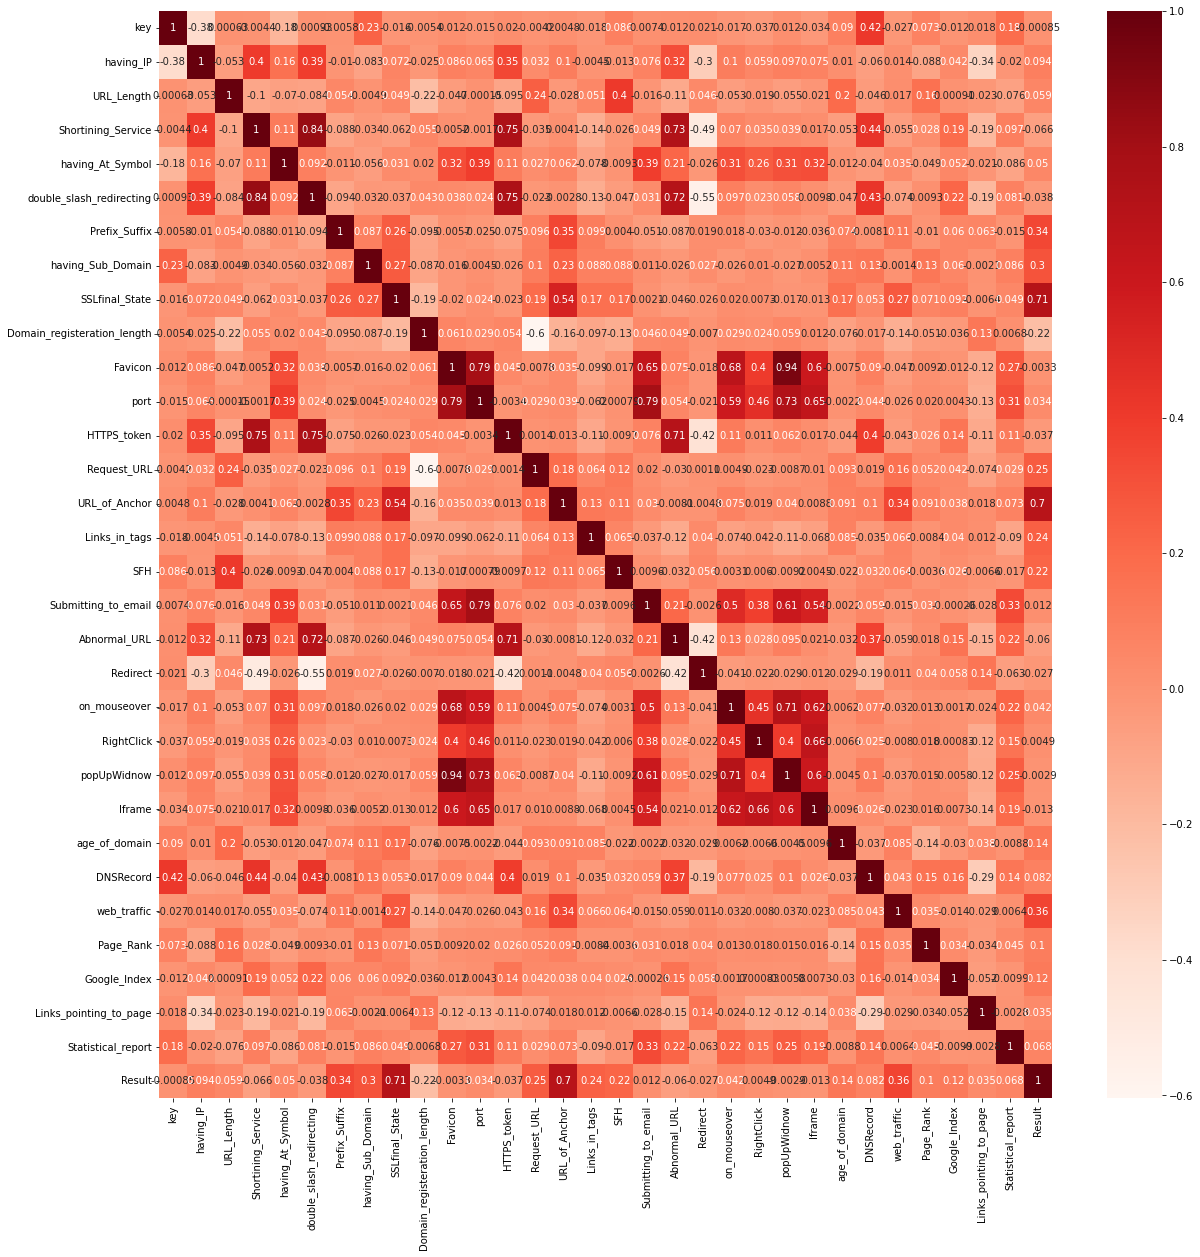

In [25]:
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = train_raw.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Let's check features with high correlation to the Result. 

In [29]:
#Correlation with output variable
cor_target = abs(cor["Result"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

Prefix_Suffix                  0.344660
having_Sub_Domain              0.296728
SSLfinal_State                 0.712543
Domain_registeration_length    0.219960
Request_URL                    0.254572
URL_of_Anchor                  0.696394
Links_in_tags                  0.238802
SFH                            0.217931
web_traffic                    0.355581
Result                         1.000000
Name: Result, dtype: float64

We may further just drop one of these two features, in case these features are highly correlated to each other. 

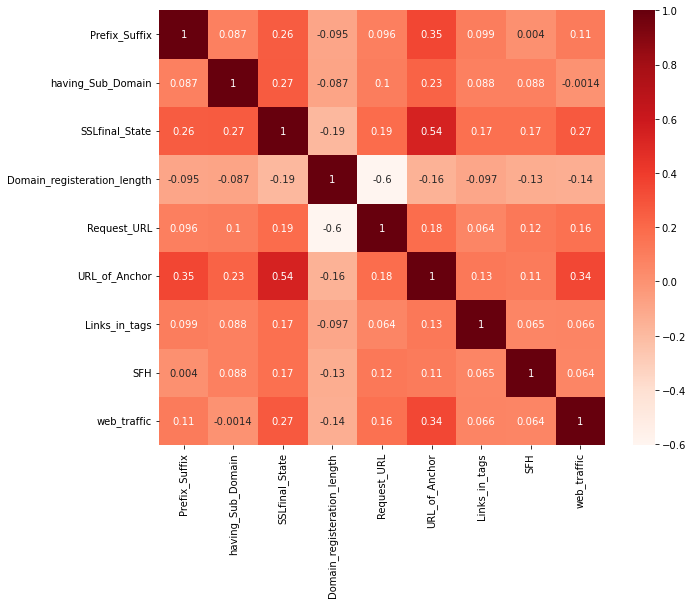

In [37]:
#Using Pearson Correlation
plt.figure(figsize=(10,8))
close_cor = train_raw[["Prefix_Suffix", "having_Sub_Domain", "SSLfinal_State", "Domain_registeration_length","Request_URL", "URL_of_Anchor", "Links_in_tags", "SFH", "web_traffic"]].corr()
sns.heatmap(close_cor, annot=True, cmap=plt.cm.Reds)
plt.show()

We may go ahead with these features, none of them seem to highly correlated with each other. URL_of_Anchor and SSLfinal_State have 0.54 correlation, but these features show even higher corr with the result. So let's go ahead with these features.

In [40]:
train_feat = train_raw[["Prefix_Suffix", "having_Sub_Domain", "SSLfinal_State", "Domain_registeration_length","Request_URL", "URL_of_Anchor", "Links_in_tags", "SFH", "web_traffic", "Result"]]
train_feat.head(5)

,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Request_URL,URL_of_Anchor,Links_in_tags,SFH,web_traffic,Result
0,-1,-1,-1,-1,1,-1,1,-1,-1,-1
1,-1,0,1,-1,1,0,-1,-1,0,-1
2,-1,-1,-1,-1,1,0,-1,-1,1,-1
3,-1,-1,-1,1,-1,0,0,-1,1,-1
4,-1,1,1,-1,1,0,0,-1,0,1


Just to verify out own performance, let's create a validation set:

In [56]:
X = train_feat[["Prefix_Suffix", "having_Sub_Domain", "SSLfinal_State", "Domain_registeration_length","Request_URL", "URL_of_Anchor", "Links_in_tags", "SFH", "web_traffic"]]
y = train_feat['Result']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=False)
print(X_train.shape, X_val.shape)

(7164, 9) (1791, 9)


In [57]:
X_train.head(5)

,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Request_URL,URL_of_Anchor,Links_in_tags,SFH,web_traffic
0,-1,-1,-1,-1,1,-1,1,-1,-1
1,-1,0,1,-1,1,0,-1,-1,0
2,-1,-1,-1,-1,1,0,-1,-1,1
3,-1,-1,-1,1,-1,0,0,-1,1
4,-1,1,1,-1,1,0,0,-1,0


In [87]:
X_test = test_raw[["Prefix_Suffix", "having_Sub_Domain", "SSLfinal_State", "Domain_registeration_length","Request_URL", "URL_of_Anchor", "Links_in_tags", "SFH", "web_traffic"]]

### Logistic Regression

In [60]:
lr_model = LogisticRegression(random_state=0).fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)

In [62]:
accuracy_score(y_val, lr_pred)

0.9106644332774986

Okay wow, so we did see an accuracy of upto 91% with logistic regression. 

So we now understand that these features are contributing well to the prediction. We may now look into ensemble model, the well-known Decision Tree!

### Decision Tree

We see slight improvement in the accuracy, but not very substantial. Let's try making the model better, with entropy as criterion. 

In [66]:
dt_model = DecisionTreeClassifier(random_state=0, criterion = 'entropy').fit(X_train, y_train)
dt_pred = dt_model.predict(X_val)

In [67]:
accuracy_score(y_val, dt_pred)

0.9195979899497487

### XGBoost

In [69]:
xg_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
xg_pred = xg_model.predict(X_val)

In [70]:
accuracy_score(y_val, xg_pred)

0.9173646007816862

After observing that all the models predict approximately similar in terms of accuracy, I planned on looking into false negatives, since a phishing site being tagged as legitimate could lead to heavy loss. Let's look at recall for each model.

In [83]:
# Logistic Regression:

recall_score(y_val, lr_pred)

0.9275929549902152

In [84]:
# Decision Trees:

recall_score(y_val, dt_pred)

0.9452054794520548

In [85]:
# XGBoost:

recall_score(y_val, xg_pred)

0.949119373776908

Overall, XGBoost has given us pretty good results.

In [88]:
test_pred = xg_model.predict(X_test)

In [99]:
test_pred

array([ 1, -1, -1, ..., -1, -1,  1], dtype=int64)

In [107]:
result_df = pd.DataFrame(test_raw['key'])
result_df['Result'] = test_pred.tolist()

In [111]:
result_df.to_csv("Submission.csv", encoding='utf-8', index=False, header=True)

In [108]:
result_df.head(2)

,key,Result
0,21338,1
1,21339,-1
